In [1]:
import numpy as np  
import pandas as pd  
import matplotlib.pyplot as plt  
from PIL import Image
from scipy.io import loadmat  
from scipy import stats  
from scipy.stats import multivariate_normal
import re
import glob
from operator import itemgetter 
import random

from support_functions import *

from keras.layers import Input, Dense
from keras.models import Model
from keras.models import load_model

Using TensorFlow backend.


## Read Data

In [2]:
label_1_folder = [9,21]      # Images in this folder will be labeled as anomaly
target_folders = range(1,22) # Read these folders
data_path = "CroppedYale/"   # Source folder

# Read image matrix (n*m), labels (vector of m), and image size
imgs, labels, height, width = get_data(label_1_folder,target_folders,data_path)

574  images are above our threshold and thus removed from the list


### Load the Saved Autoencoder Model

In [3]:
# Generate and Compile a Deep Autoencoder
img_size = height*width
autoencoder = compile_autoencoder(imgs, img_size)

# Load the saved model
autoencoder = load_model('model_autoencoder.h5')
# encoder = load_model('model_encoder.h5')

### Visualize the Reconstructed Image

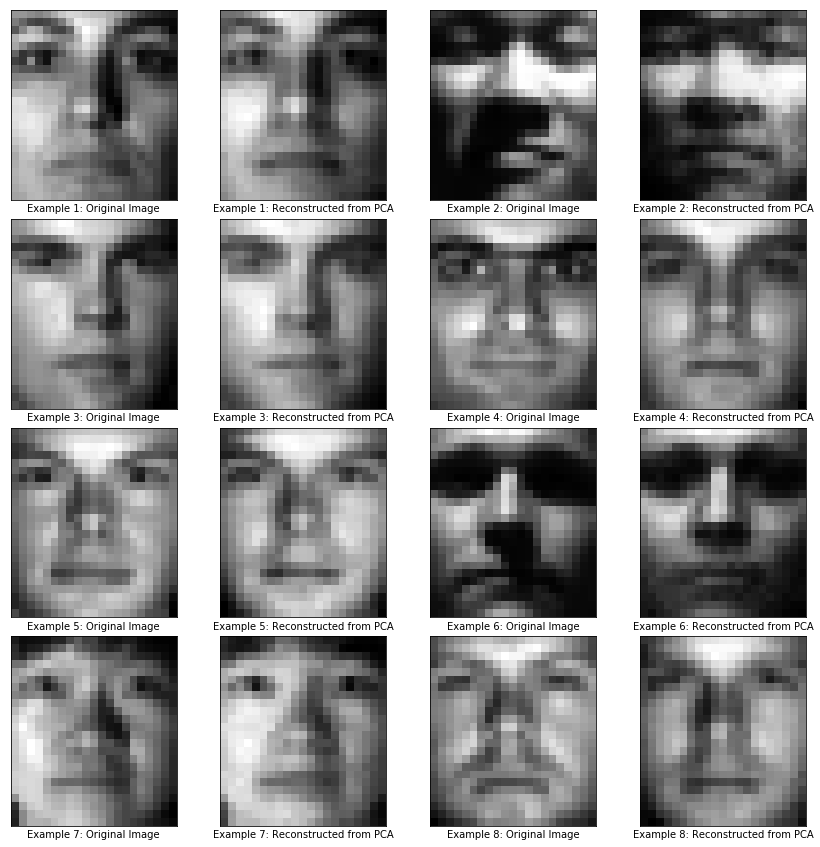

In [4]:
imgs_trans = np.transpose(imgs) # Transpose
imgs_trans = imgs_trans.astype('float32') / 255. # Resize
# Load into the model and get the processed output
imgs_reconst = np.transpose(autoencoder.predict(imgs_trans))

# Plot the original images and their reconstructed version for comparison
plot_compare_after_reconst(imgs_reconst,imgs,height,width)

## Anomaly Detection with Reconstruction Error

In [5]:
# Split the images and labels
# By default: 80% in training and 20% in testing
train_ind, test_ind = split_training(labels)
x_all = np.transpose(imgs)
x_train = x_all[train_ind,:]
x_test = x_all[test_ind,:]
labels_train = labels[train_ind]
labels_test = labels[test_ind]

# Normalize the Data
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

# Reconstruct both training and testing data with Deep Autoencoder
reconst_train = np.transpose(autoencoder.predict(x_train))
reconst_test = np.transpose(autoencoder.predict(x_test))

The higher the reconstruction error, the more likely the point will be an anomaly


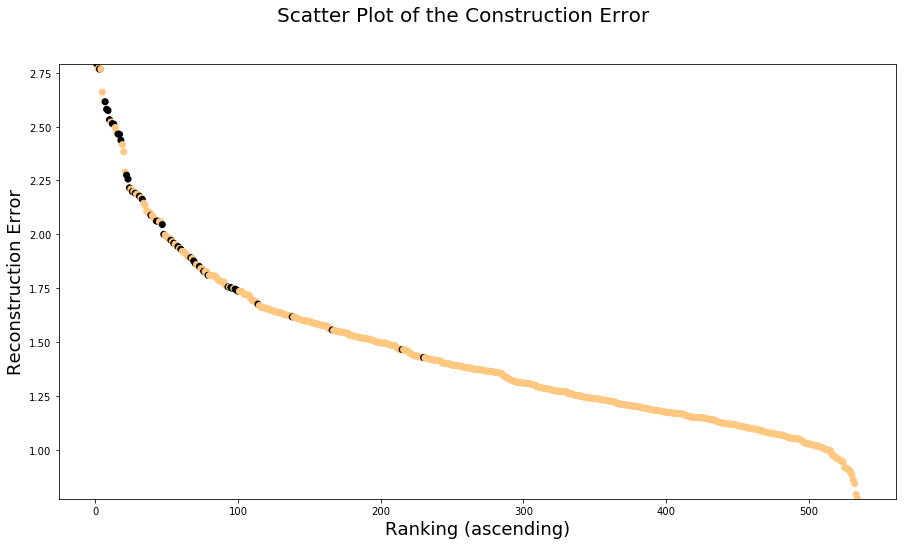

In [6]:
# Find the euclidean distance between the reconstructed dataset and the original ()
dist_train = find_euclidean_distance(reconst_train,np.transpose(x_train))
print("The higher the reconstruction error, the more likely the point will be an anomaly")
plot_scatter_with_labels(dist_train,labels_train)

In [7]:
threshold_error, tpr,tnr,fpr,fnr,f1 = select_threshold_distance(dist_train, labels_train,to_print = True)

True Positive Rate: 75.0%
True Negative Rate: 90.6%
False Positive Rate: 9.4%
False Negative Rate: 25.0%
F-score: 53.7%


### Evaluate the Detector with the Testing Dataset

In [8]:
# Find the euclidean distance between the reconstructed dataset and the original ()
dist_test = find_euclidean_distance(reconst_test,np.transpose(x_test))

# Sort the Images and Labels based on the Probability
rank_test = np.argsort(-dist_test) # Sort from the Largest to the Smallest
dist_test_ranked = dist_test[rank_test] # Sort the distance
# Rank Labels
labels_test_ranked = labels_test[rank_test]
# Give Predictions
preds = np.zeros(labels_test.shape) # Initialization
preds[dist_test_ranked > threshold_error] = 1

# Evaluate the Detector with Testing Data
eval_with_test(preds, labels_test_ranked, k = 10)

Precision: 54.2%
Recall: 68.4%
F-score: 60.5%
Precision@10: 60.0%


## Anomaly Detection with Gaussian Distribution